In [1]:
import pystrata

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pystrata.motion import TimeSeriesMotion

In [3]:
def time_accel_txt_to_pystrata_motion(filename: str) -> TimeSeriesMotion:
    df = pd.read_csv(filename, header=None, skiprows=2, encoding = "utf-8", delim_whitespace=True)
    accels = df[1].to_numpy()
    time_step = df[0][1] - df[0][0]

    return TimeSeriesMotion(filename=filename, description='', time_step=time_step, accels=accels)

In [4]:
ts =  time_accel_txt_to_pystrata_motion('ATH49901T2.txt')

In [5]:
ts.accels

array([-1.63098879e-05, -1.12130479e-04, -3.70030581e-04, ...,
       -1.43934760e-03, -1.22222222e-03, -3.28236493e-04])

In [6]:
print(ts.time_step)

0.005


In [7]:
# Increased figure sizes
plt.rcParams["figure.dpi"] =120

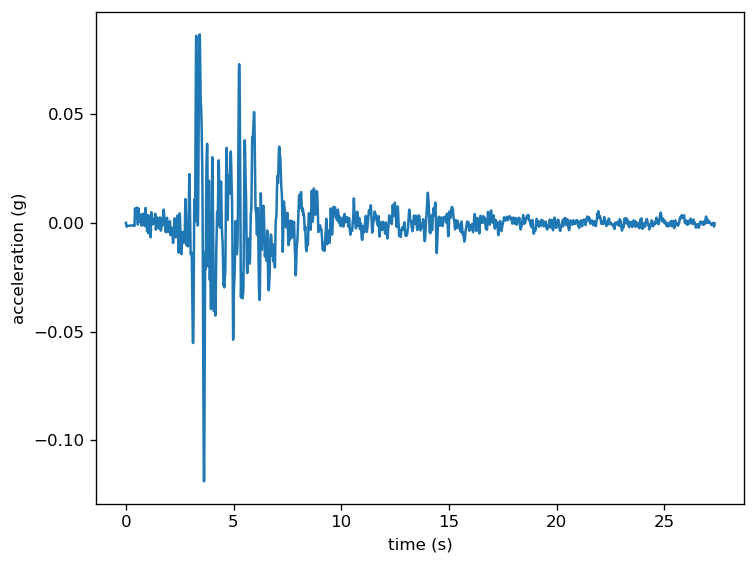

In [8]:
fig, ax = plt.subplots()
ax.plot(ts.times, ts.accels)
ax.set(xlabel='time (s)', ylabel='acceleration (g)')
fig.tight_layout()

In [9]:
profile = pystrata.site.Profile(
    [
        pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(16.0, plas_index=0, ocr=1, stress_mean=40),
            5,
            140,
        ),
        pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(18.0, plas_index=25, ocr=1, stress_mean=215),
            15,
            250,
        ),
        pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(20.0, plas_index=0, ocr=1, stress_mean=650),
            30,
            450,
        ),
        pystrata.site.Layer(pystrata.site.SoilType("Rock", 23.0, None, 0.02), 0, 1200),
    ]
).auto_discretize()

<AxesSubplot:xlabel='Initial $V_s$ (m/s)', ylabel='Depth (m)'>

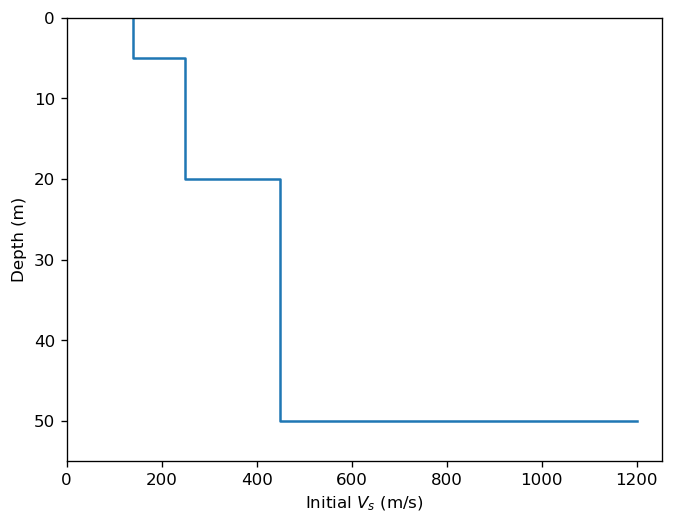

In [10]:
profile.plot("initial_shear_vel")

In [11]:
calcs = [
    pystrata.propagation.EquivalentLinearCalculator()
]

In [12]:
freqs = np.logspace(-1, 2, num=113)

outputs = pystrata.output.OutputCollection(
    [
        pystrata.output.ResponseSpectrumOutput(
            # Frequency
            freqs,
            # Location of the output
            pystrata.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ), 
        pystrata.output.AccelTransferFunctionOutput(
            # Frequency
            freqs,
            # Location in (denominator),
            pystrata.output.OutputLocation("outcrop", index=-1),
            # Location out (numerator)
            pystrata.output.OutputLocation("outcrop", index=0),
        ),
       
    ]
)

In [13]:
motion = pystrata.motion.TimeSeriesMotion('ATH49901T2.txt', description='', time_step=ts.time_step, accels=ts.accels)

In [14]:
for c in calcs:
    c(motion, profile, profile.location("outcrop", index=-1))
    outputs(c, f"{c.strain_limit:0.2f}")

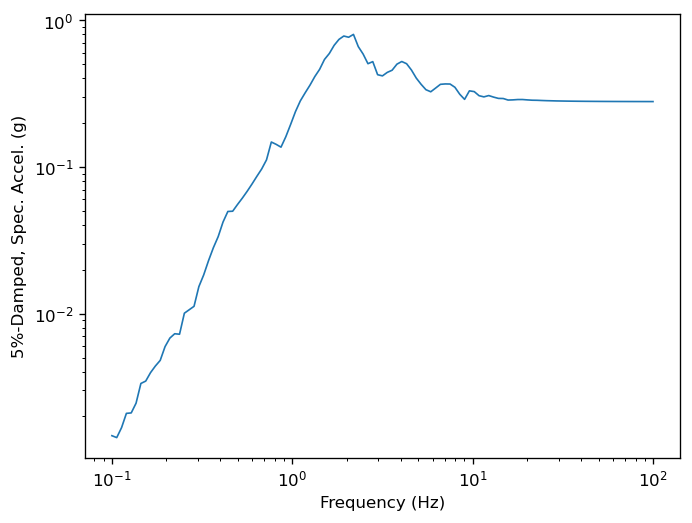

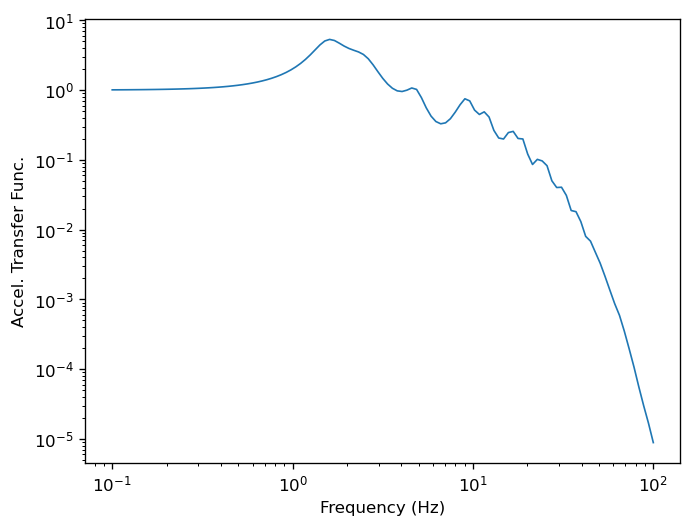

In [15]:
for o in outputs[:2]:
    ax = o.plot(style="indiv")

In [16]:
df = outputs[0].to_dataframe()
df

,0.05
0.100000,0.001477
0.106362,0.001433
0.113128,0.001676
0.120325,0.002096
0.127980,0.002111
...,...
78.137074,0.278479
83.108005,0.278435
88.395177,0.278396
94.018709,0.278361


### ΕΞΑΓΩΓΗ ΣΕ ΑΡΧΕΙΟ xls

In [17]:
df = outputs[0].to_dataframe()
df.to_excel('ATHENS DARENDELI.xlsx', index=True)

In [18]:
df = outputs[1].to_dataframe()
df

,0.05
0.100000,1.005888
0.106362,1.006744
0.113128,1.007655
0.120325,1.008623
0.127980,1.009841
...,...
78.137074,0.000107
83.108005,0.000056
88.395177,0.000030
94.018709,0.000017


In [19]:
df = outputs[1].to_dataframe()
df.to_excel('ATHENS EQL TRANSFER FUNCTION.xlsx', index=True)